In [2]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn

In [3]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(2,20),
            nn.Tanh(),
            nn.Linear(20,30),
            nn.Tanh(),
            nn.Linear(30,30),
            nn.Tanh(),
            nn.Linear(30,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,1)
        )
    
    def forward(self, x):
        out = self.net(x)
        return out

In [5]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        
        self.model = NN().to(device)
        
        # computational domain 
        self.h = 0.1 # dx
        self.k = 0.1 # dt
        x = torch.arange(-1, 1+self.h, self.h) # -1 <= x <= 1
        t = torch.arange(0, 1+self.k, self.k)  #  0 <= t <= 1
        
        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
        
        # train data
        bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2,-1).T
        bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T
        ic  = torch.stack(torch.meshgrid(x,t[0])).reshape(2,-1).T
        self.X_train = torch.cat([bc1, bc2, ic])
        
        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic  = -torch.sin(math.pi * ic[:,0])
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)
        
        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True
        
        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 50000,
            max_eval = 50000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )
        
        self.criterion = torch.nn.MSELoss()
        self.iter = 1
    
    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()
        
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)
        
        u = self.model(self.X)

        # Compute du(x,t)/dx, du(x,t)/dt
        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]
        
        #print(du_dX)
        #print("xxxxxxxxxxxxxxxxxxxxxxxxx")
        #print(du_dX[0])
        
        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]

        # Compute du^2(x,t)/dx^2 
        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph = True,
            retain_graph = True
        )[0]
        
        du_dxx = du_dXX[:,0]

        # 1-D Burgers Equation
        # du/dt + u du/dx = \nu du2/dx2
        loss_pde = self.criterion(du_dt + u.squeeze()*du_dx , (0.01/math.pi) * du_dxx) # LHS = RHS or LHS - RHS = 0-tensor
        
        loss = loss_pde + loss_data
        loss.backward()
        
        if self.iter % 100 == 0:
            print(self.iter, loss.item())
        self.iter = self.iter+1
        
        return loss
    
    def train(self):
        self.model.train()
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)
    
    def eval_(self):
        self.model.eval()

In [6]:
# training
net = Net()
net.train()

/home/ctutum/anaconda3/envs/PYTORCHenv/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403380481/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


100 0.14879415929317474
200 0.09380216896533966
300 0.08515623211860657
400 0.06850258260965347
500 0.05071716755628586
600 0.032129205763339996
700 0.021927528083324432
800 0.02365325763821602
900 0.01841813512146473
1000 0.014600388705730438
1100 0.008792776614427567
1200 0.005991211161017418
1300 0.004490538965910673
1400 0.003343635005876422
1500 0.002679918659850955
1600 0.027460653334856033
1700 0.0017408534185960889
1800 0.0015496223932132125
1900 0.0013748521450906992
2000 0.0010980607476085424
2100 0.0008726336527615786
2200 0.0006800479022786021
2300 0.0005371071165427566
2400 0.00044682115549221635
2500 0.0003792420029640198
2600 0.0003184976812917739
2700 0.00025129871210083365
2800 0.00020864716498181224
2900 0.000178207439603284
3000 0.0001504951505921781
3100 0.0001420653279637918
3200 0.00012877264816779643
3300 0.00011611965601332486
3400 0.00010822554759215564
3500 9.82659257715568e-05
3600 8.889789751265198e-05
3700 8.107396570267156e-05
3800 7.535904296673834e-05
39

In [7]:
net.model.eval()

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
    (6): Linear(in_features=30, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [8]:
h = 0.01
k = 0.01

x = torch.arange(-1,1,h)
t = torch.arange(0,1,k)

X= torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X= X.to(net.X.device)

In [9]:
X

tensor([[-1.0000,  0.0000],
        [-1.0000,  0.0100],
        [-1.0000,  0.0200],
        ...,
        [ 0.9900,  0.9700],
        [ 0.9900,  0.9800],
        [ 0.9900,  0.9900]], device='cuda:0')

In [10]:
X.shape

torch.Size([20000, 2])

In [11]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x),len(t)).cpu().numpy()

In [12]:
y_pred.shape

(200, 100)

In [13]:
y_pred

array([[ 0.00344278,  0.0029296 ,  0.0024793 , ..., -0.00122322,
        -0.00121535, -0.00120909],
       [ 0.03492867,  0.03348451,  0.03215211, ...,  0.00636344,
         0.00631015,  0.0062569 ],
       [ 0.06622262,  0.0638624 ,  0.06166037, ...,  0.01395999,
         0.01384639,  0.01373388],
       ...,
       [-0.09622493, -0.09349042, -0.09093228, ..., -0.02550415,
        -0.02531473, -0.0251262 ],
       [-0.06380646, -0.06204746, -0.06041446, ..., -0.017808  ,
        -0.01768361, -0.01755853],
       [-0.03100198, -0.03024359, -0.02955797, ..., -0.0101207 ,
        -0.01006074, -0.00999967]], dtype=float32)

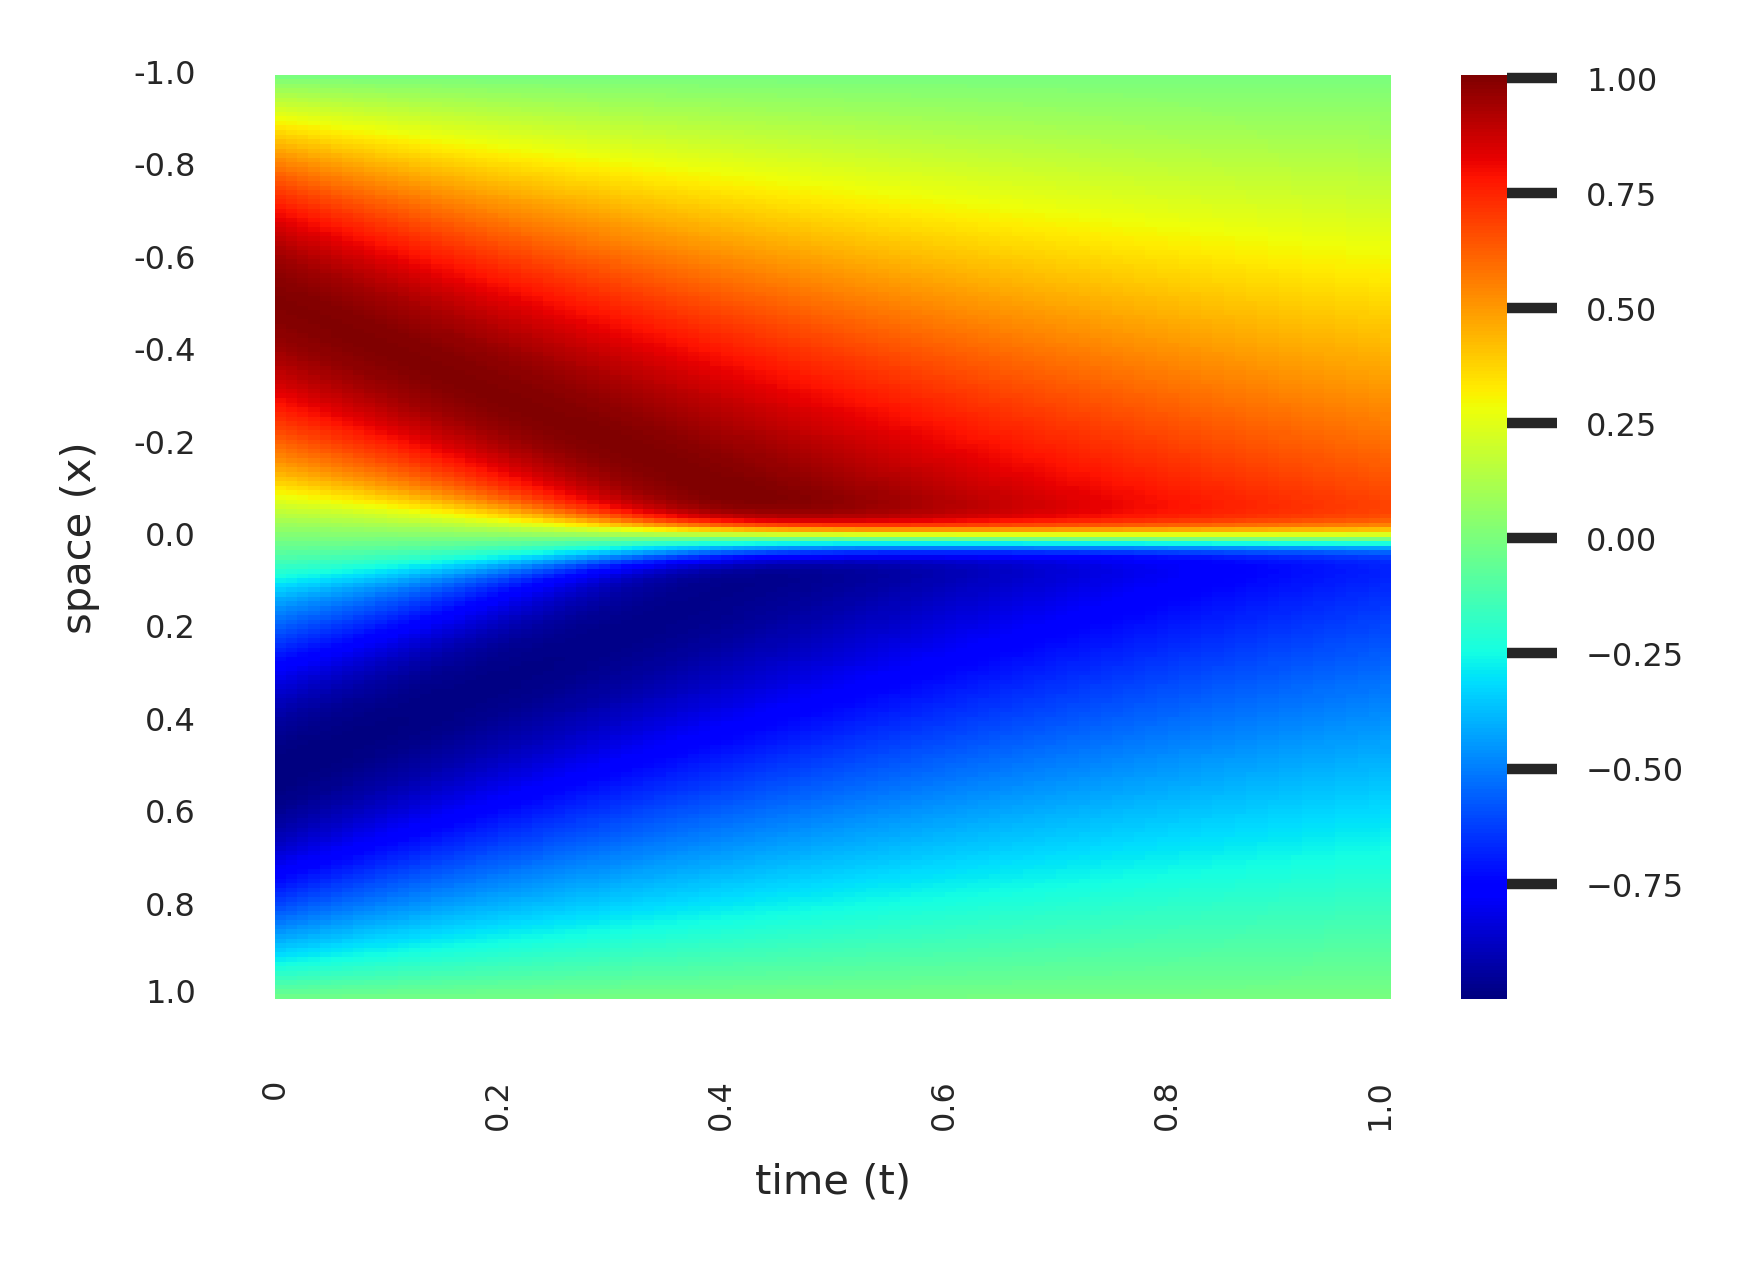

In [46]:
sns.set_style("white")
sns.set(font_scale = 0.35)
plt.figure(figsize=(3,2), dpi=600)
ax = sns.heatmap(y_pred, cmap='jet')
plt.xticks([0, 20, 40, 60, 80, 99], ['0', '0.2', '0.4', '0.6', '0.8', '1.0'])
plt.yticks([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 199], 
           ['-1.0', '-0.8', '-0.6', '-0.4', '-0.2', '0.0', '0.2', '0.4', '0.6', '0.8', '1.0'])
ax.set_xlabel("time (t)", fontsize=5)
ax.set_ylabel("space (x)", fontsize=5)
plt.savefig('PINNs_1D_Burgers_contour.png', bbox_inches='tight')

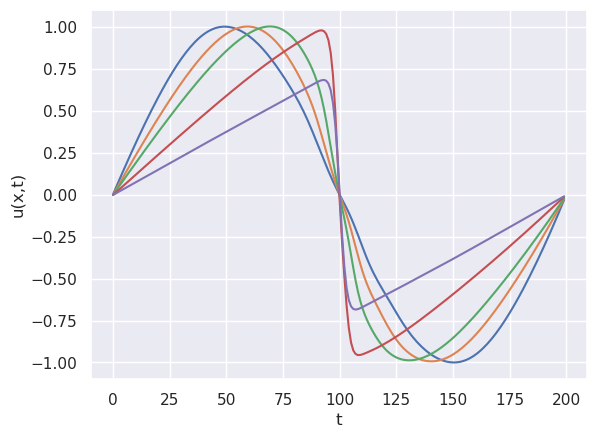

In [61]:
sns.set(font_scale = 1)
plt.plot(y_pred[:,[0, 10, 20, 50, -1]] )
plt.xlabel("t", fontsize=12)
plt.ylabel("u(x,t)", fontsize=12)
plt.savefig('PINNs_1D_Burgers_time-evol.png', bbox_inches='tight', dpi=600)